# Setup and Imports

In [ ]:
!pip install rasterio segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import segmentation_models_pytorch as smp

# Paths
base_path = "/content/drive/MyDrive/Final Tif Files "
NODATA_VAL = -9999


# Utility Functions

In [ ]:
def load_and_prepare(composite_path, vnl_path=None):
    with rio.open(composite_path) as src:
        X = src.read().astype(np.float32)
        meta = src.meta.copy()
    X[X == NODATA_VAL] = np.nan
    for b in range(X.shape[0]):
        band = X[b]
        min_val, max_val = np.nanmin(band), np.nanmax(band)
        if max_val > min_val:
            X[b] = (band - min_val) / (max_val - min_val)
    if vnl_path:
        with rio.open(vnl_path) as src:
            y = src.read(1).astype(np.float32)
        y[y == NODATA_VAL] = np.nan
        return X, y, meta
    return X, None, meta

def create_valid_tiles(X, y, tile_size=128, stride=64):
    H, W = y.shape
    X_tiles, y_tiles = [], []
    for i in range(0, H - tile_size + 1, stride):
        for j in range(0, W - tile_size + 1, stride):
            x_patch = X[:, i:i+tile_size, j:j+tile_size]
            y_patch = y[i:i+tile_size, j:j+tile_size]
            if np.isnan(x_patch).any() or np.isnan(y_patch).any():
                continue
            X_tiles.append(np.moveaxis(x_patch, 0, -1))
            y_tiles.append(y_patch[..., np.newaxis])
    return np.array(X_tiles), np.array(y_tiles)


# DeepLabV3+ Model Setup & Training (Cairo 2021)

In [ ]:
# Load and tile 2021 data
file_train_X = os.path.join(base_path, "Composite_Cairo_Train_2021_cleaned.tif")
file_train_y = os.path.join(base_path, "VNL_Cairo_2021_Final.tif")
X_raw, y_raw, _ = load_and_prepare(file_train_X, file_train_y)
X_tiles, y_tiles = create_valid_tiles(X_raw, y_raw)

X_train, X_val, y_train, y_val = train_test_split(X_tiles, y_tiles, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).squeeze(3)
X_val_tensor = torch.tensor(X_val.transpose(0, 3, 1, 2), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).squeeze(3)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=8, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=12,
    classes=1,
    activation=None
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses, val_losses = [], []

def train_deeplab(model, train_loader, val_loader, epochs=20):
    for epoch in range(epochs):
        model.train()
        train_loss, val_loss = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb).squeeze(1)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).squeeze(1)
                val_loss += criterion(preds, yb).item()
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs} — Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

train_deeplab(model, train_loader, val_loader, epochs=30)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Epoch 1/30 — Train Loss: 908.9421, Val Loss: 722.7065
Epoch 2/30 — Train Loss: 709.0007, Val Loss: 593.7569
Epoch 3/30 — Train Loss: 553.4508, Val Loss: 589.9930
Epoch 4/30 — Train Loss: 413.0340, Val Loss: 239.5270
Epoch 5/30 — Train Loss: 328.7163, Val Loss: 169.8787
Epoch 6/30 — Train Loss: 265.9275, Val Loss: 285.9734
Epoch 7/30 — Train Loss: 195.6712, Val Loss: 230.0315
Epoch 8/30 — Train Loss: 162.6000, Val Loss: 91.3099
Epoch 9/30 — Train Loss: 128.9918, Val Loss: 106.8608
Epoch 10/30 — Train Loss: 103.8832, Val Loss: 67.4575
Epoch 11/30 — Train Loss: 85.0553, Val Loss: 67.1922
Epoch 12/30 — Train Loss: 89.9729, Val Loss: 64.9417
Epoch 13/30 — Train Loss: 84.2331, Val Loss: 111.3981
Epoch 14/30 — Train Loss: 69.6312, Val Loss: 79.5981
Epoch 15/30 — Train Loss: 53.1923, Val Loss: 49.7253
Epoch 16/30 — Train Loss: 54.4981, Val Loss: 53.9991
Epoch 17/30 — Train Loss: 57.0512, Val Loss: 87.4989
Epoch 18/30 — Train Loss: 44.1860, Val Loss: 47.9772
Epoch 19/30 — Train Loss: 45.1420, V

# Training Loss Visualization

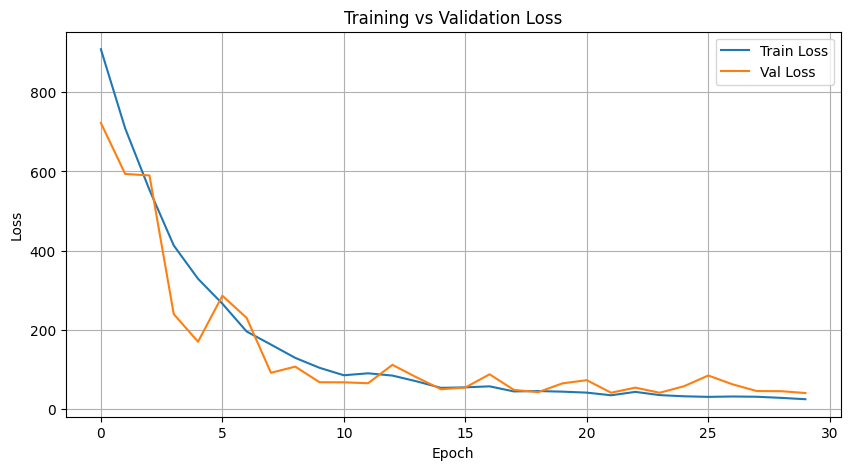

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# Prediction Function (Reusable)

In [ ]:
def predict_full_map(model, composite_raw, tile_size=128, stride=64):
    model.eval()
    _, H, W = composite_raw.shape
    pred_map = np.zeros((H, W), dtype=np.float32)
    counts = np.zeros((H, W), dtype=np.uint8)

    for i in range(0, H - tile_size + 1, stride):
        for j in range(0, W - tile_size + 1, stride):
            patch = composite_raw[:, i:i+tile_size, j:j+tile_size]
            if np.isnan(patch).any() or patch.shape[1:] != (tile_size, tile_size):
                continue
            patch_tensor = torch.tensor(patch, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                pred = model(patch_tensor).cpu().squeeze().numpy()
            pred_map[i:i+tile_size, j:j+tile_size] += pred
            counts[i:i+tile_size, j:j+tile_size] += 1

    counts[counts == 0] = 1
    return pred_map / counts


# Predict & Evaluate: Cairo 2023

In [ ]:
# Load 2023 test data
file_test_X_2023 = os.path.join(base_path, "Composite_Cairo_2023_Test_cleaned.tif")
file_test_y_2023 = os.path.join(base_path, "VNL_Cairo_2023_Test_Clipped.tif")

X_test_raw, y_test_raw, meta_2023 = load_and_prepare(file_test_X_2023, file_test_y_2023)
pred_map_2023 = predict_full_map(model, X_test_raw)

# Save predicted map
meta_2023.update({"count": 1, "dtype": "float32"})
with rio.open("Predicted_Dev_Map_DeepLab_Cairo_2023.tif", "w", **meta_2023) as dst:
    dst.write(pred_map_2023[np.newaxis, :, :])


# Advanced Evaluation for Cairo 2023

In [ ]:
# Align shapes
y_true = y_test_raw[:pred_map_2023.shape[0], :pred_map_2023.shape[1]]
y_pred = pred_map_2023
valid_mask = ~np.isnan(y_true)

y_true_flat = y_true[valid_mask]
y_pred_flat = y_pred[valid_mask]

# Standard metrics
mae = mean_absolute_error(y_true_flat, y_pred_flat)
rmse = mean_squared_error(y_true_flat, y_pred_flat)**0.5
r2 = r2_score(y_true_flat, y_pred_flat)
print(f"✅ [Cairo 2023] MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


✅ [Cairo 2023] MAE: 8.13, RMSE: 11.31, R²: 0.8207


# Full Visualization for Cairo 2023

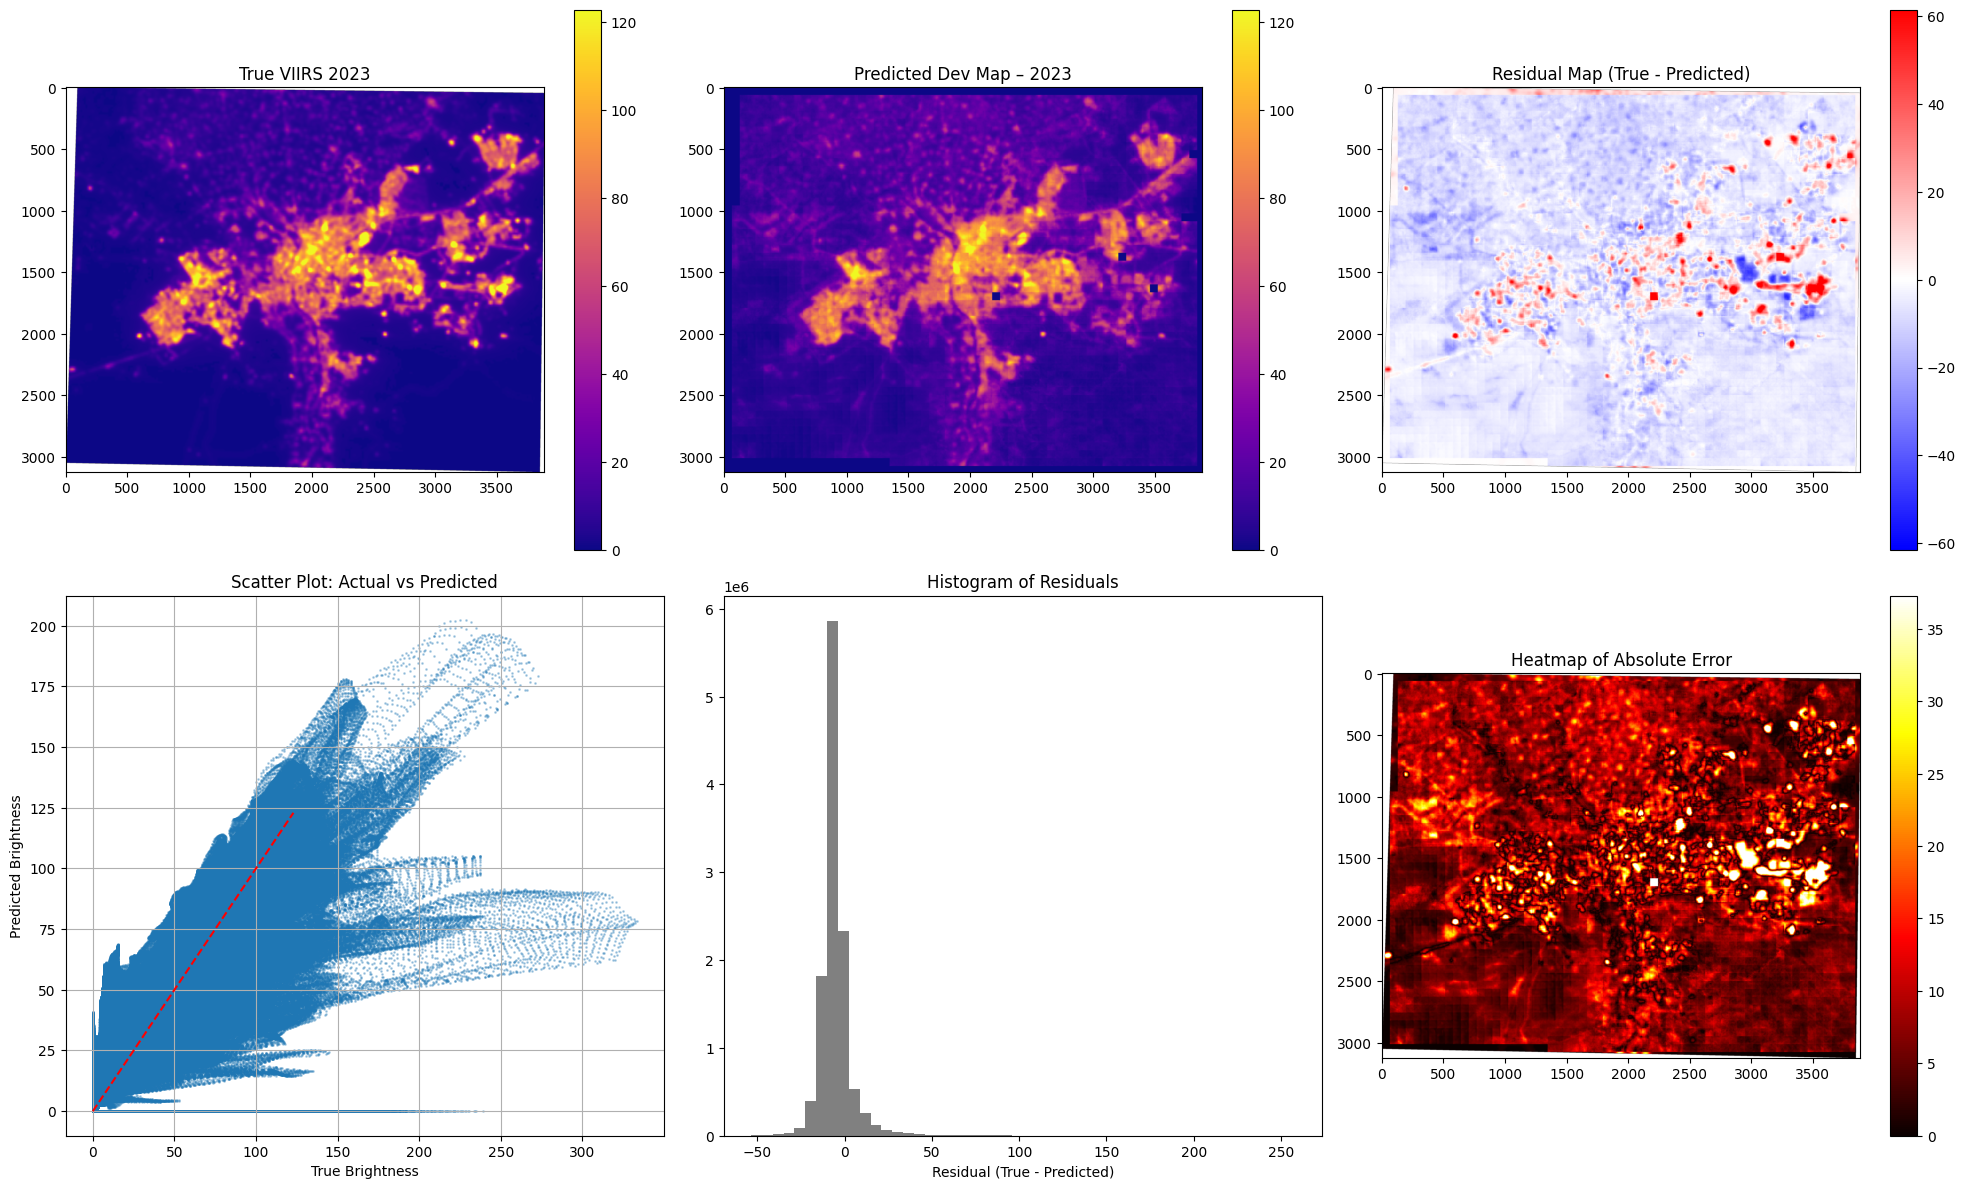

In [ ]:
vmax = np.nanpercentile(y_true, 99.5)
residuals = y_true - y_pred
abs_error = np.abs(residuals)

plt.figure(figsize=(20, 12))

# True Map
plt.subplot(2, 3, 1)
plt.imshow(y_true, cmap='plasma', vmin=0, vmax=vmax)
plt.title("True VIIRS 2023")
plt.colorbar()

# Predicted Map
plt.subplot(2, 3, 2)
plt.imshow(y_pred, cmap='plasma', vmin=0, vmax=vmax)
plt.title("Predicted Dev Map – 2023")
plt.colorbar()

# Residual Map
plt.subplot(2, 3, 3)
plt.imshow(residuals, cmap='bwr', vmin=-vmax/2, vmax=vmax/2)
plt.title("Residual Map (True - Predicted)")
plt.colorbar()

# Scatter Plot
plt.subplot(2, 3, 4)
plt.scatter(y_true_flat, y_pred_flat, alpha=0.3, s=1)
plt.plot([0, vmax], [0, vmax], 'r--')
plt.xlabel("True Brightness")
plt.ylabel("Predicted Brightness")
plt.title("Scatter Plot: Actual vs Predicted")
plt.grid(True)

# Histogram of Residuals
plt.subplot(2, 3, 5)
plt.hist(residuals[valid_mask].flatten(), bins=50, color='gray')
plt.title("Histogram of Residuals")
plt.xlabel("Residual (True - Predicted)")

# Absolute Error Heatmap
plt.subplot(2, 3, 6)
plt.imshow(abs_error, cmap='hot', vmin=0, vmax=np.nanpercentile(abs_error, 99))
plt.title("Heatmap of Absolute Error")
plt.colorbar()

plt.tight_layout()
plt.show()


# Quantile Bin Comparison

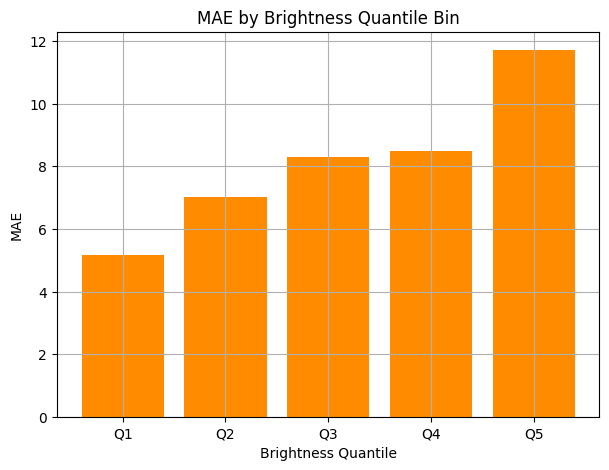

In [ ]:
bins = np.nanpercentile(y_true_flat, [0, 20, 40, 60, 80, 100])
labels = ["Q1", "Q2", "Q3", "Q4", "Q5"]
digitized = np.digitize(y_true_flat, bins) - 1

bin_mae = [mean_absolute_error(y_true_flat[digitized == i], y_pred_flat[digitized == i]) for i in range(5)]

plt.figure(figsize=(7, 5))
plt.bar(labels, bin_mae, color='darkorange')
plt.title("MAE by Brightness Quantile Bin")
plt.xlabel("Brightness Quantile")
plt.ylabel("MAE")
plt.grid(True)
plt.show()


# Cairo 2025 – Future Prediction

In [ ]:
# Load 2025 data (no VNL available)
file_pred_X_2025 = os.path.join(base_path, "Composite_Cairo_2025_Prediction_cleaned.tif")
X_pred_2025_raw, _, meta_2025 = load_and_prepare(file_pred_X_2025, None)

# Predict future development
pred_map_2025 = predict_full_map(model, X_pred_2025_raw)

# Save predicted map
meta_2025.update({"count": 1, "dtype": "float32"})
with rio.open("Predicted_Dev_Map_DeepLab_Cairo_2025.tif", "w", **meta_2025) as dst:
    dst.write(pred_map_2025[np.newaxis, :, :])


# Visualize Predicted Economic Development – Cairo 2025

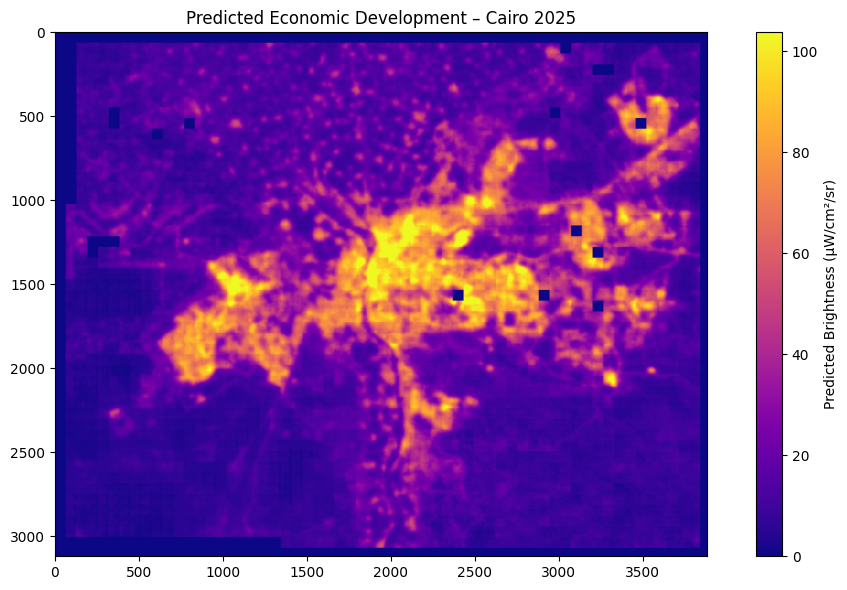

In [ ]:
vmax_2025 = np.nanpercentile(pred_map_2025, 99.5)

plt.figure(figsize=(10, 6))
plt.imshow(pred_map_2025, cmap="plasma", vmin=0, vmax=vmax_2025)
plt.colorbar(label="Predicted Brightness (µW/cm²/sr)")
plt.title("Predicted Economic Development – Cairo 2025")
plt.tight_layout()
plt.show()


# Predict & Evaluate: Cairo 2015

In [ ]:
# Load 2015 data
file_test_X_2015 = os.path.join(base_path, "Composite_Cairo_2015_cleaned.tif")
file_test_y_2015 = os.path.join(base_path, "VNL_Cairo_2015_Final.tif")

X_test_2015_raw, y_test_2015_raw, meta_2015 = load_and_prepare(file_test_X_2015, file_test_y_2015)
pred_map_2015 = predict_full_map(model, X_test_2015_raw)

# Save prediction
meta_2015.update({"count": 1, "dtype": "float32"})
with rio.open("Predicted_Dev_Map_DeepLab_Cairo_2015.tif", "w", **meta_2015) as dst:
    dst.write(pred_map_2015[np.newaxis, :, :])


# Full Evaluation for Cairo 2015

In [ ]:
# Align shapes
y_true_2015 = y_test_2015_raw[:pred_map_2015.shape[0], :pred_map_2015.shape[1]]
y_pred_2015 = pred_map_2015
valid_mask = ~np.isnan(y_true_2015)

y_true_flat = y_true_2015[valid_mask]
y_pred_flat = y_pred_2015[valid_mask]

# Metrics
mae_2015 = mean_absolute_error(y_true_flat, y_pred_flat)
rmse_2015 = mean_squared_error(y_true_flat, y_pred_flat)**0.5
r2_2015 = r2_score(y_true_flat, y_pred_flat)
print(f"✅ [Cairo 2015] MAE: {mae_2015:.2f}, RMSE: {rmse_2015:.2f}, R²: {r2_2015:.4f}")


✅ [Cairo 2015] MAE: 9.11, RMSE: 18.71, R²: 0.4709


# Visual Analysis for Cairo 2015

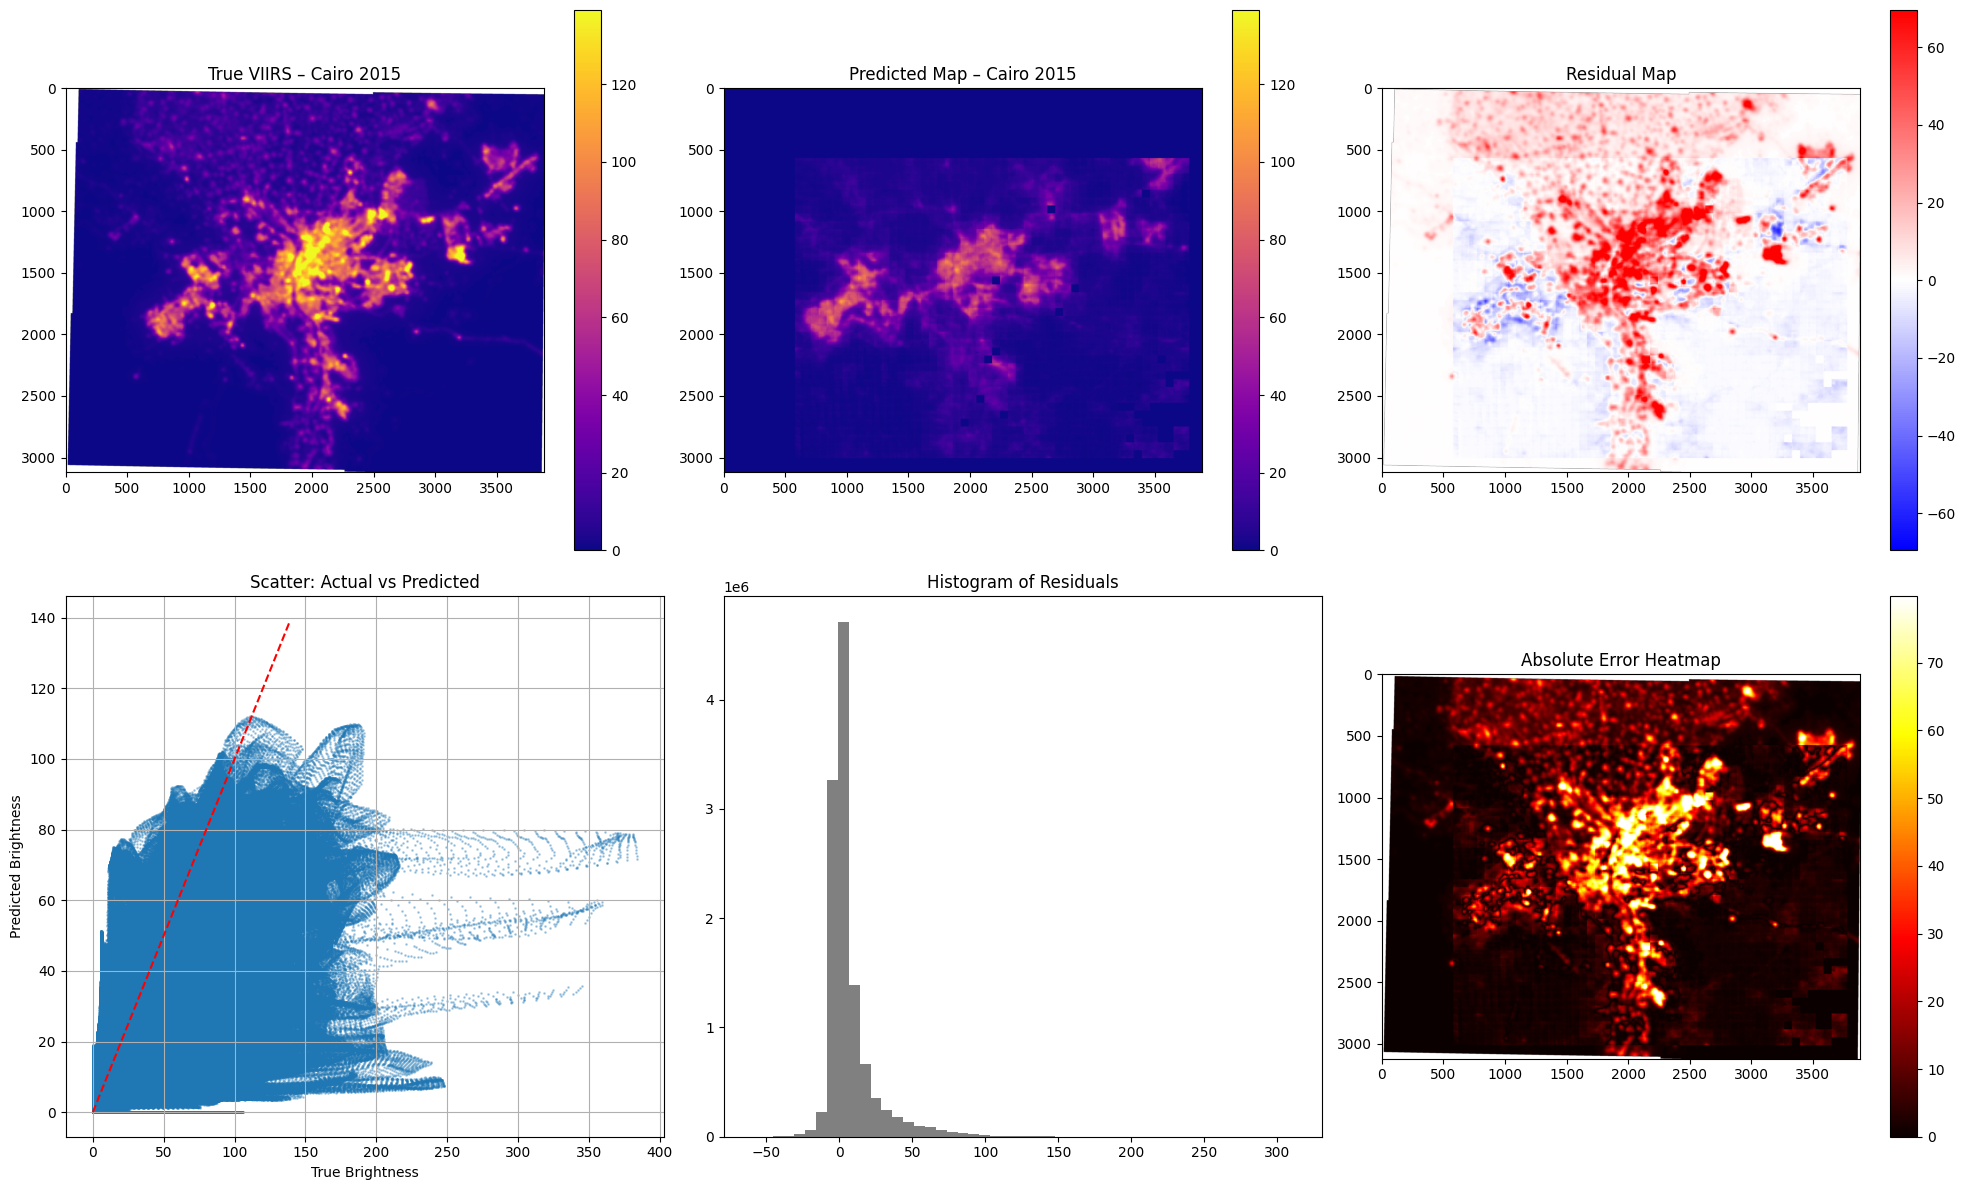

In [ ]:
vmax_2015 = np.nanpercentile(y_true_2015, 99.5)
residuals_2015 = y_true_2015 - y_pred_2015
abs_error_2015 = np.abs(residuals_2015)

plt.figure(figsize=(20, 12))

# True VIIRS
plt.subplot(2, 3, 1)
plt.imshow(y_true_2015, cmap='plasma', vmin=0, vmax=vmax_2015)
plt.title("True VIIRS – Cairo 2015")
plt.colorbar()

# Predicted Map
plt.subplot(2, 3, 2)
plt.imshow(y_pred_2015, cmap='plasma', vmin=0, vmax=vmax_2015)
plt.title("Predicted Map – Cairo 2015")
plt.colorbar()

# Residual Map
plt.subplot(2, 3, 3)
plt.imshow(residuals_2015, cmap='bwr', vmin=-vmax_2015/2, vmax=vmax_2015/2)
plt.title("Residual Map")
plt.colorbar()

# Scatter Plot
plt.subplot(2, 3, 4)
plt.scatter(y_true_flat, y_pred_flat, alpha=0.3, s=1)
plt.plot([0, vmax_2015], [0, vmax_2015], 'r--')
plt.title("Scatter: Actual vs Predicted")
plt.xlabel("True Brightness")
plt.ylabel("Predicted Brightness")
plt.grid(True)

# Histogram
plt.subplot(2, 3, 5)
plt.hist(residuals_2015[valid_mask].flatten(), bins=50, color='gray')
plt.title("Histogram of Residuals")

# Error Heatmap
plt.subplot(2, 3, 6)
plt.imshow(abs_error_2015, cmap='hot', vmin=0, vmax=np.nanpercentile(abs_error_2015, 99))
plt.title("Absolute Error Heatmap")
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
# Save model weights
torch.save(model.state_dict(), "DeepLabV3Plus_Cairo2021_Weights.pth")
print("✅ Model weights saved to DeepLabV3Plus_Cairo2021_Weights.pth")


✅ Model weights saved to DeepLabV3Plus_Cairo2021_Weights.pth


# Predict & Evaluate: Cairo 2018

In [ ]:
# Load 2018 data
file_test_X_2018 = os.path.join(base_path, "Composite_Cairo_2018_cleaned.tif")
file_test_y_2018 = os.path.join(base_path, "VNL_Cairo_2018_Final.tif")

X_test_2018_raw, y_test_2018_raw, meta_2018 = load_and_prepare(file_test_X_2018, file_test_y_2018)
pred_map_2018 = predict_full_map(model, X_test_2018_raw)

# Save predicted map
meta_2018.update({"count": 1, "dtype": "float32"})
with rio.open("Predicted_Dev_Map_DeepLab_Cairo_2018.tif", "w", **meta_2018) as dst:
    dst.write(pred_map_2018[np.newaxis, :, :])


# Evaluation for Cairo 2018


In [ ]:
# Align and mask
y_true_2018 = y_test_2018_raw[:pred_map_2018.shape[0], :pred_map_2018.shape[1]]
y_pred_2018 = pred_map_2018
valid_mask = ~np.isnan(y_true_2018)

y_true_flat = y_true_2018[valid_mask]
y_pred_flat = y_pred_2018[valid_mask]

# Metrics
mae_2018 = mean_absolute_error(y_true_flat, y_pred_flat)
rmse_2018 = mean_squared_error(y_true_flat, y_pred_flat)**0.5
r2_2018 = r2_score(y_true_flat, y_pred_flat)
print(f"✅ [Cairo 2018] MAE: {mae_2018:.2f}, RMSE: {rmse_2018:.2f}, R²: {r2_2018:.4f}")


# Visuals for Cairo 2018

In [ ]:
vmax_2018 = np.nanpercentile(y_true_2018, 99.5)
residuals_2018 = y_true_2018 - y_pred_2018
abs_error_2018 = np.abs(residuals_2018)

plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.imshow(y_true_2018, cmap='plasma', vmin=0, vmax=vmax_2018)
plt.title("True VIIRS – Cairo 2018")
plt.colorbar()

plt.subplot(2, 3, 2)
plt.imshow(y_pred_2018, cmap='plasma', vmin=0, vmax=vmax_2018)
plt.title("Predicted Map – Cairo 2018")
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(residuals_2018, cmap='bwr', vmin=-vmax_2018/2, vmax=vmax_2018/2)
plt.title("Residual Map")
plt.colorbar()

plt.subplot(2, 3, 4)
plt.scatter(y_true_flat, y_pred_flat, alpha=0.3, s=1)
plt.plot([0, vmax_2018], [0, vmax_2018], 'r--')
plt.title("Scatter: Actual vs Predicted")
plt.grid(True)

plt.subplot(2, 3, 5)
plt.hist(residuals_2018[valid_mask].flatten(), bins=50, color='gray')
plt.title("Histogram of Residuals")

plt.subplot(2, 3, 6)
plt.imshow(abs_error_2018, cmap='hot', vmin=0, vmax=np.nanpercentile(abs_error_2018, 99))
plt.title("Absolute Error Heatmap")
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
# 1. Re-import libraries and re-initialize the model
import segmentation_models_pytorch as smp
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights="imagenet",  # or None if you're running offline
    in_channels=12,
    classes=1,
    activation=None
).to(device)

# 2. Load trained weights
model.load_state_dict(torch.load("DeepLabV3Plus_Cairo2021_Weights.pth"))
model.eval()  # Important for inference


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

# Predict & Evaluate: Cairo 2019

In [ ]:
# Load 2019 data
file_test_X_2019 = os.path.join(base_path, "Composite_Cairo_2019_cleaned.tif")
file_test_y_2019 = os.path.join(base_path, "VNL_Cairo_2019_Final.tif")

X_test_2019_raw, y_test_2019_raw, meta_2019 = load_and_prepare(file_test_X_2019, file_test_y_2019)
pred_map_2019 = predict_full_map(model, X_test_2019_raw)

# Save predicted map
meta_2019.update({"count": 1, "dtype": "float32"})
with rio.open("Predicted_Dev_Map_DeepLab_Cairo_2019.tif", "w", **meta_2019) as dst:
    dst.write(pred_map_2019[np.newaxis, :, :])


# Evaluation for Cairo 2019

In [ ]:
# Align and mask
y_true_2019 = y_test_2019_raw[:pred_map_2019.shape[0], :pred_map_2019.shape[1]]
y_pred_2019 = pred_map_2019
valid_mask = ~np.isnan(y_true_2019)

y_true_flat = y_true_2019[valid_mask]
y_pred_flat = y_pred_2019[valid_mask]

# Metrics
mae_2019 = mean_absolute_error(y_true_flat, y_pred_flat)
rmse_2019 = mean_squared_error(y_true_flat, y_pred_flat)**0.5
r2_2019 = r2_score(y_true_flat, y_pred_flat)
print(f"✅ [Cairo 2019] MAE: {mae_2019:.2f}, RMSE: {rmse_2019:.2f}, R²: {r2_2019:.4f}")


✅ [Cairo 2019] MAE: 9.20, RMSE: 18.89, R²: 0.5155


# Visuals for Cairo 2019

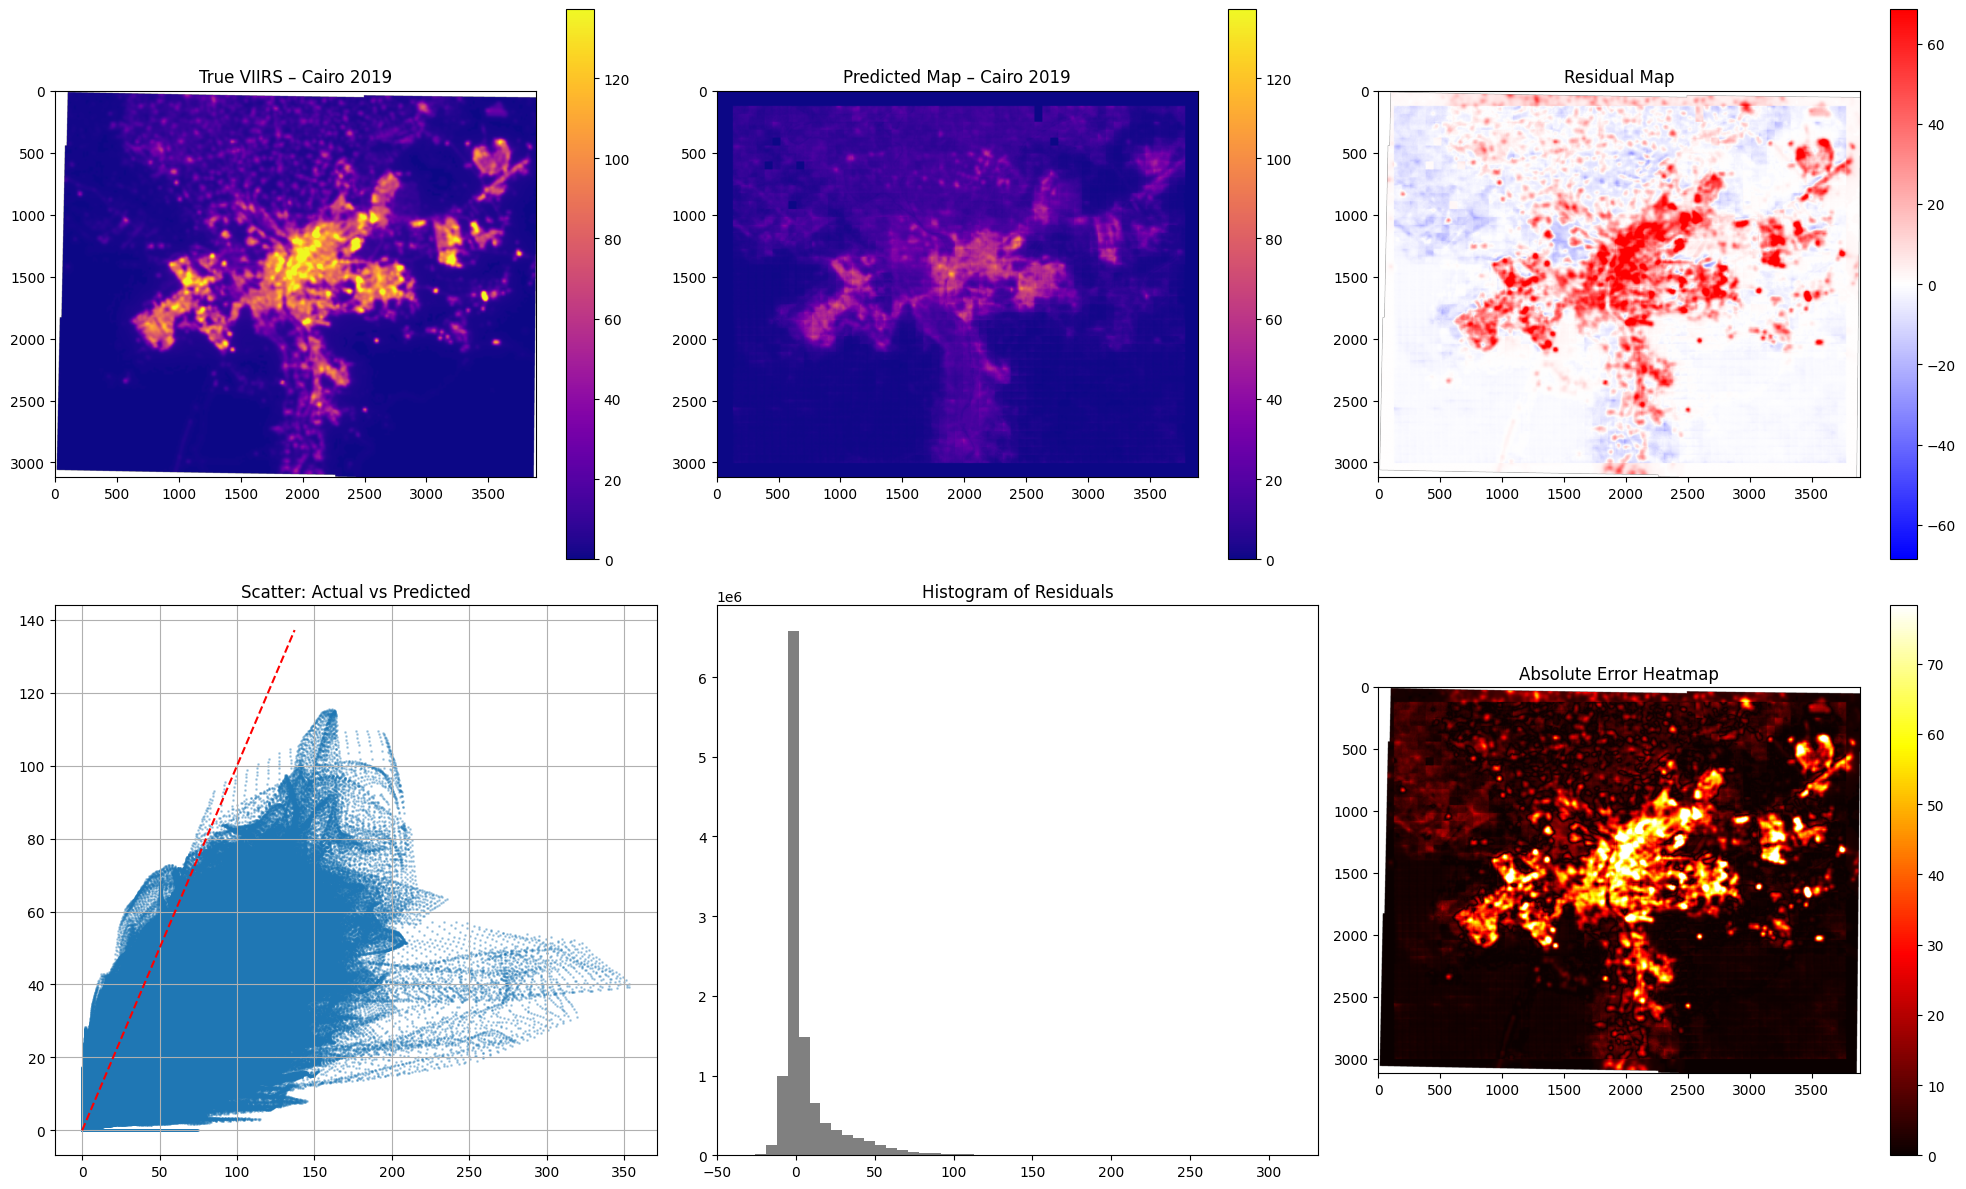

In [ ]:
vmax_2019 = np.nanpercentile(y_true_2019, 99.5)
residuals_2019 = y_true_2019 - y_pred_2019
abs_error_2019 = np.abs(residuals_2019)

plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.imshow(y_true_2019, cmap='plasma', vmin=0, vmax=vmax_2019)
plt.title("True VIIRS – Cairo 2019")
plt.colorbar()

plt.subplot(2, 3, 2)
plt.imshow(y_pred_2019, cmap='plasma', vmin=0, vmax=vmax_2019)
plt.title("Predicted Map – Cairo 2019")
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(residuals_2019, cmap='bwr', vmin=-vmax_2019/2, vmax=vmax_2019/2)
plt.title("Residual Map")
plt.colorbar()

plt.subplot(2, 3, 4)
plt.scatter(y_true_flat, y_pred_flat, alpha=0.3, s=1)
plt.plot([0, vmax_2019], [0, vmax_2019], 'r--')
plt.title("Scatter: Actual vs Predicted")
plt.grid(True)

plt.subplot(2, 3, 5)
plt.hist(residuals_2019[valid_mask].flatten(), bins=50, color='gray')
plt.title("Histogram of Residuals")

plt.subplot(2, 3, 6)
plt.imshow(abs_error_2019, cmap='hot', vmin=0, vmax=np.nanpercentile(abs_error_2019, 99))
plt.title("Absolute Error Heatmap")
plt.colorbar()

plt.tight_layout()
plt.show()


# Predict & Evaluate: Cairo 2020

In [ ]:
# Load 2020 data
file_test_X_2020 = os.path.join(base_path, "Composite_Cairo_2020_cleaned.tif")
file_test_y_2020 = os.path.join(base_path, "VNL_Cairo_2020_Final.tif")

X_test_2020_raw, y_test_2020_raw, meta_2020 = load_and_prepare(file_test_X_2020, file_test_y_2020)
pred_map_2020 = predict_full_map(model, X_test_2020_raw)

# Save predicted map
meta_2020.update({"count": 1, "dtype": "float32"})
with rio.open("Predicted_Dev_Map_DeepLab_Cairo_2020.tif", "w", **meta_2020) as dst:
    dst.write(pred_map_2020[np.newaxis, :, :])


# Evaluation for Cairo 2020

In [ ]:
y_true_2020 = y_test_2020_raw[:pred_map_2020.shape[0], :pred_map_2020.shape[1]]
y_pred_2020 = pred_map_2020
valid_mask = ~np.isnan(y_true_2020)

y_true_flat = y_true_2020[valid_mask]
y_pred_flat = y_pred_2020[valid_mask]

mae_2020 = mean_absolute_error(y_true_flat, y_pred_flat)
rmse_2020 = mean_squared_error(y_true_flat, y_pred_flat)**0.5
r2_2020 = r2_score(y_true_flat, y_pred_flat)
print(f"✅ [Cairo 2020] MAE: {mae_2020:.2f}, RMSE: {rmse_2020:.2f}, R²: {r2_2020:.4f}")


✅ [Cairo 2020] MAE: 9.25, RMSE: 16.69, R²: 0.5368


# Visuals for Cairo 2020

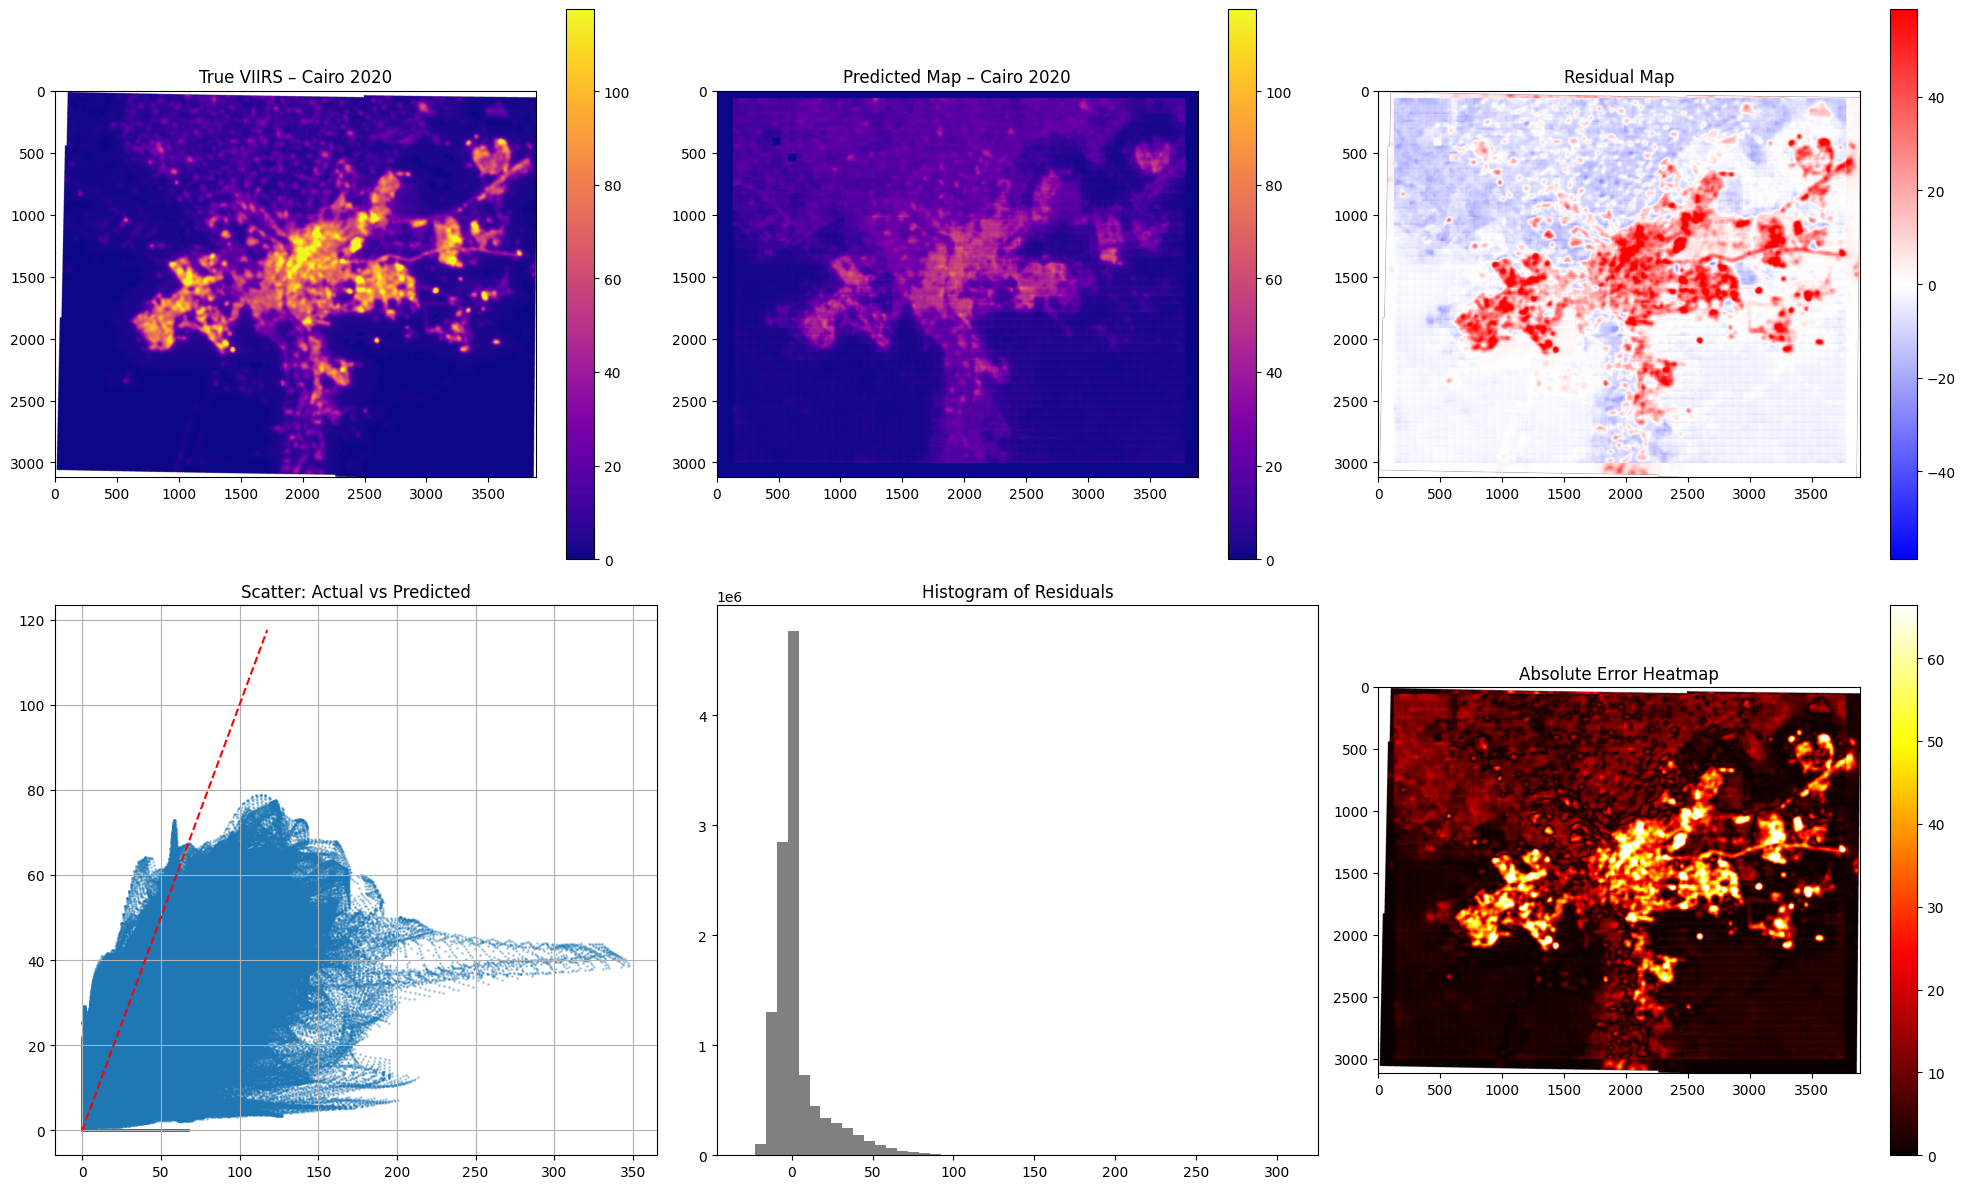

In [ ]:
vmax_2020 = np.nanpercentile(y_true_2020, 99.5)
residuals_2020 = y_true_2020 - y_pred_2020
abs_error_2020 = np.abs(residuals_2020)

plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.imshow(y_true_2020, cmap='plasma', vmin=0, vmax=vmax_2020)
plt.title("True VIIRS – Cairo 2020")
plt.colorbar()

plt.subplot(2, 3, 2)
plt.imshow(y_pred_2020, cmap='plasma', vmin=0, vmax=vmax_2020)
plt.title("Predicted Map – Cairo 2020")
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(residuals_2020, cmap='bwr', vmin=-vmax_2020/2, vmax=vmax_2020/2)
plt.title("Residual Map")
plt.colorbar()

plt.subplot(2, 3, 4)
plt.scatter(y_true_flat, y_pred_flat, alpha=0.3, s=1)
plt.plot([0, vmax_2020], [0, vmax_2020], 'r--')
plt.title("Scatter: Actual vs Predicted")
plt.grid(True)

plt.subplot(2, 3, 5)
plt.hist(residuals_2020[valid_mask].flatten(), bins=50, color='gray')
plt.title("Histogram of Residuals")

plt.subplot(2, 3, 6)
plt.imshow(abs_error_2020, cmap='hot', vmin=0, vmax=np.nanpercentile(abs_error_2020, 99))
plt.title("Absolute Error Heatmap")
plt.colorbar()

plt.tight_layout()
plt.show()


# Predict & Evaluate: Cairo 2022

In [ ]:
# Load 2022 data
file_test_X_2022 = os.path.join(base_path, "Composite_Cairo_2022_cleaned.tif")
file_test_y_2022 = os.path.join(base_path, "VNL_Cairo_2022_Final.tif")

X_test_2022_raw, y_test_2022_raw, meta_2022 = load_and_prepare(file_test_X_2022, file_test_y_2022)
pred_map_2022 = predict_full_map(model, X_test_2022_raw)

# Save predicted map
meta_2022.update({"count": 1, "dtype": "float32"})
with rio.open("Predicted_Dev_Map_DeepLab_Cairo_2022.tif", "w", **meta_2022) as dst:
    dst.write(pred_map_2022[np.newaxis, :, :])


# Evaluation for Cairo 2022

In [ ]:
y_true_2022 = y_test_2022_raw[:pred_map_2022.shape[0], :pred_map_2022.shape[1]]
y_pred_2022 = pred_map_2022
valid_mask = ~np.isnan(y_true_2022)

y_true_flat = y_true_2022[valid_mask]
y_pred_flat = y_pred_2022[valid_mask]

mae_2022 = mean_absolute_error(y_true_flat, y_pred_flat)
rmse_2022 = mean_squared_error(y_true_flat, y_pred_flat)**0.5
r2_2022 = r2_score(y_true_flat, y_pred_flat)
print(f"✅ [Cairo 2022] MAE: {mae_2022:.2f}, RMSE: {rmse_2022:.2f}, R²: {r2_2022:.4f}")


✅ [Cairo 2022] MAE: 6.78, RMSE: 14.08, R²: 0.7442


# Visuals for Cairo 2022

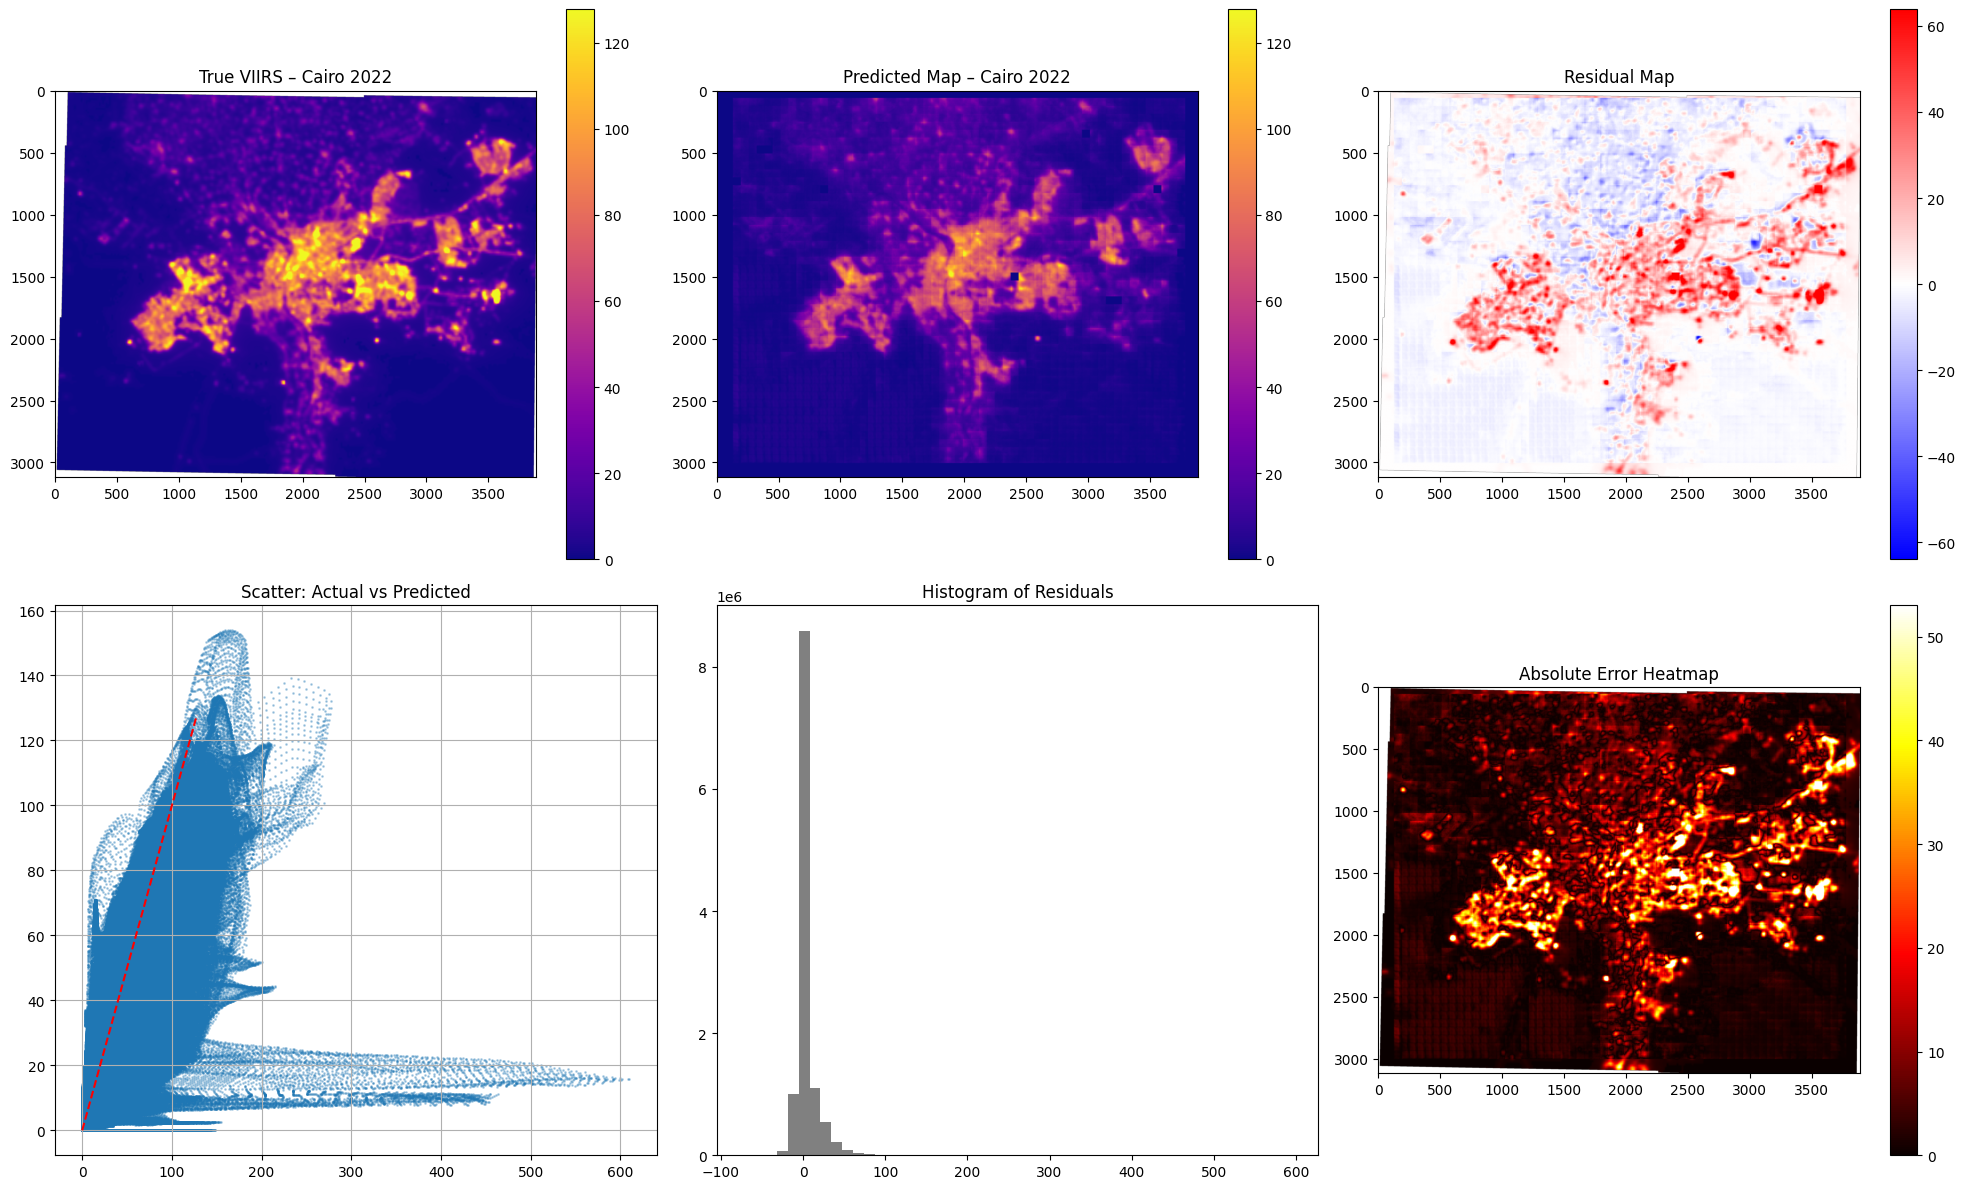

In [ ]:
vmax_2022 = np.nanpercentile(y_true_2022, 99.5)
residuals_2022 = y_true_2022 - y_pred_2022
abs_error_2022 = np.abs(residuals_2022)

plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.imshow(y_true_2022, cmap='plasma', vmin=0, vmax=vmax_2022)
plt.title("True VIIRS – Cairo 2022")
plt.colorbar()

plt.subplot(2, 3, 2)
plt.imshow(y_pred_2022, cmap='plasma', vmin=0, vmax=vmax_2022)
plt.title("Predicted Map – Cairo 2022")
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(residuals_2022, cmap='bwr', vmin=-vmax_2022/2, vmax=vmax_2022/2)
plt.title("Residual Map")
plt.colorbar()

plt.subplot(2, 3, 4)
plt.scatter(y_true_flat, y_pred_flat, alpha=0.3, s=1)
plt.plot([0, vmax_2022], [0, vmax_2022], 'r--')
plt.title("Scatter: Actual vs Predicted")
plt.grid(True)

plt.subplot(2, 3, 5)
plt.hist(residuals_2022[valid_mask].flatten(), bins=50, color='gray')
plt.title("Histogram of Residuals")

plt.subplot(2, 3, 6)
plt.imshow(abs_error_2022, cmap='hot', vmin=0, vmax=np.nanpercentile(abs_error_2022, 99))
plt.title("Absolute Error Heatmap")
plt.colorbar()

plt.tight_layout()
plt.show()


# Predict & Evaluate: Cairo 2024

In [ ]:
# Load 2024 data
file_test_X_2024 = os.path.join(base_path, "Composite_Cairo_2024_cleaned.tif")
file_test_y_2024 = os.path.join(base_path, "VNL_Cairo_2024_Final.tif")

X_test_2024_raw, y_test_2024_raw, meta_2024 = load_and_prepare(file_test_X_2024, file_test_y_2024)
pred_map_2024 = predict_full_map(model, X_test_2024_raw)

# Save predicted map
meta_2024.update({"count": 1, "dtype": "float32"})
with rio.open("Predicted_Dev_Map_DeepLab_Cairo_2024.tif", "w", **meta_2024) as dst:
    dst.write(pred_map_2024[np.newaxis, :, :])


# Evaluation for Cairo 2024

In [ ]:
y_true_2024 = y_test_2024_raw[:pred_map_2024.shape[0], :pred_map_2024.shape[1]]
y_pred_2024 = pred_map_2024
valid_mask = ~np.isnan(y_true_2024)

y_true_flat = y_true_2024[valid_mask]
y_pred_flat = y_pred_2024[valid_mask]

mae_2024 = mean_absolute_error(y_true_flat, y_pred_flat)
rmse_2024 = mean_squared_error(y_true_flat, y_pred_flat)**0.5
r2_2024 = r2_score(y_true_flat, y_pred_flat)
print(f"✅ [Cairo 2024] MAE: {mae_2024:.2f}, RMSE: {rmse_2024:.2f}, R²: {r2_2024:.4f}")


✅ [Cairo 2024] MAE: 6.68, RMSE: 12.98, R²: 0.7742


# Visuals for Cairo 2024

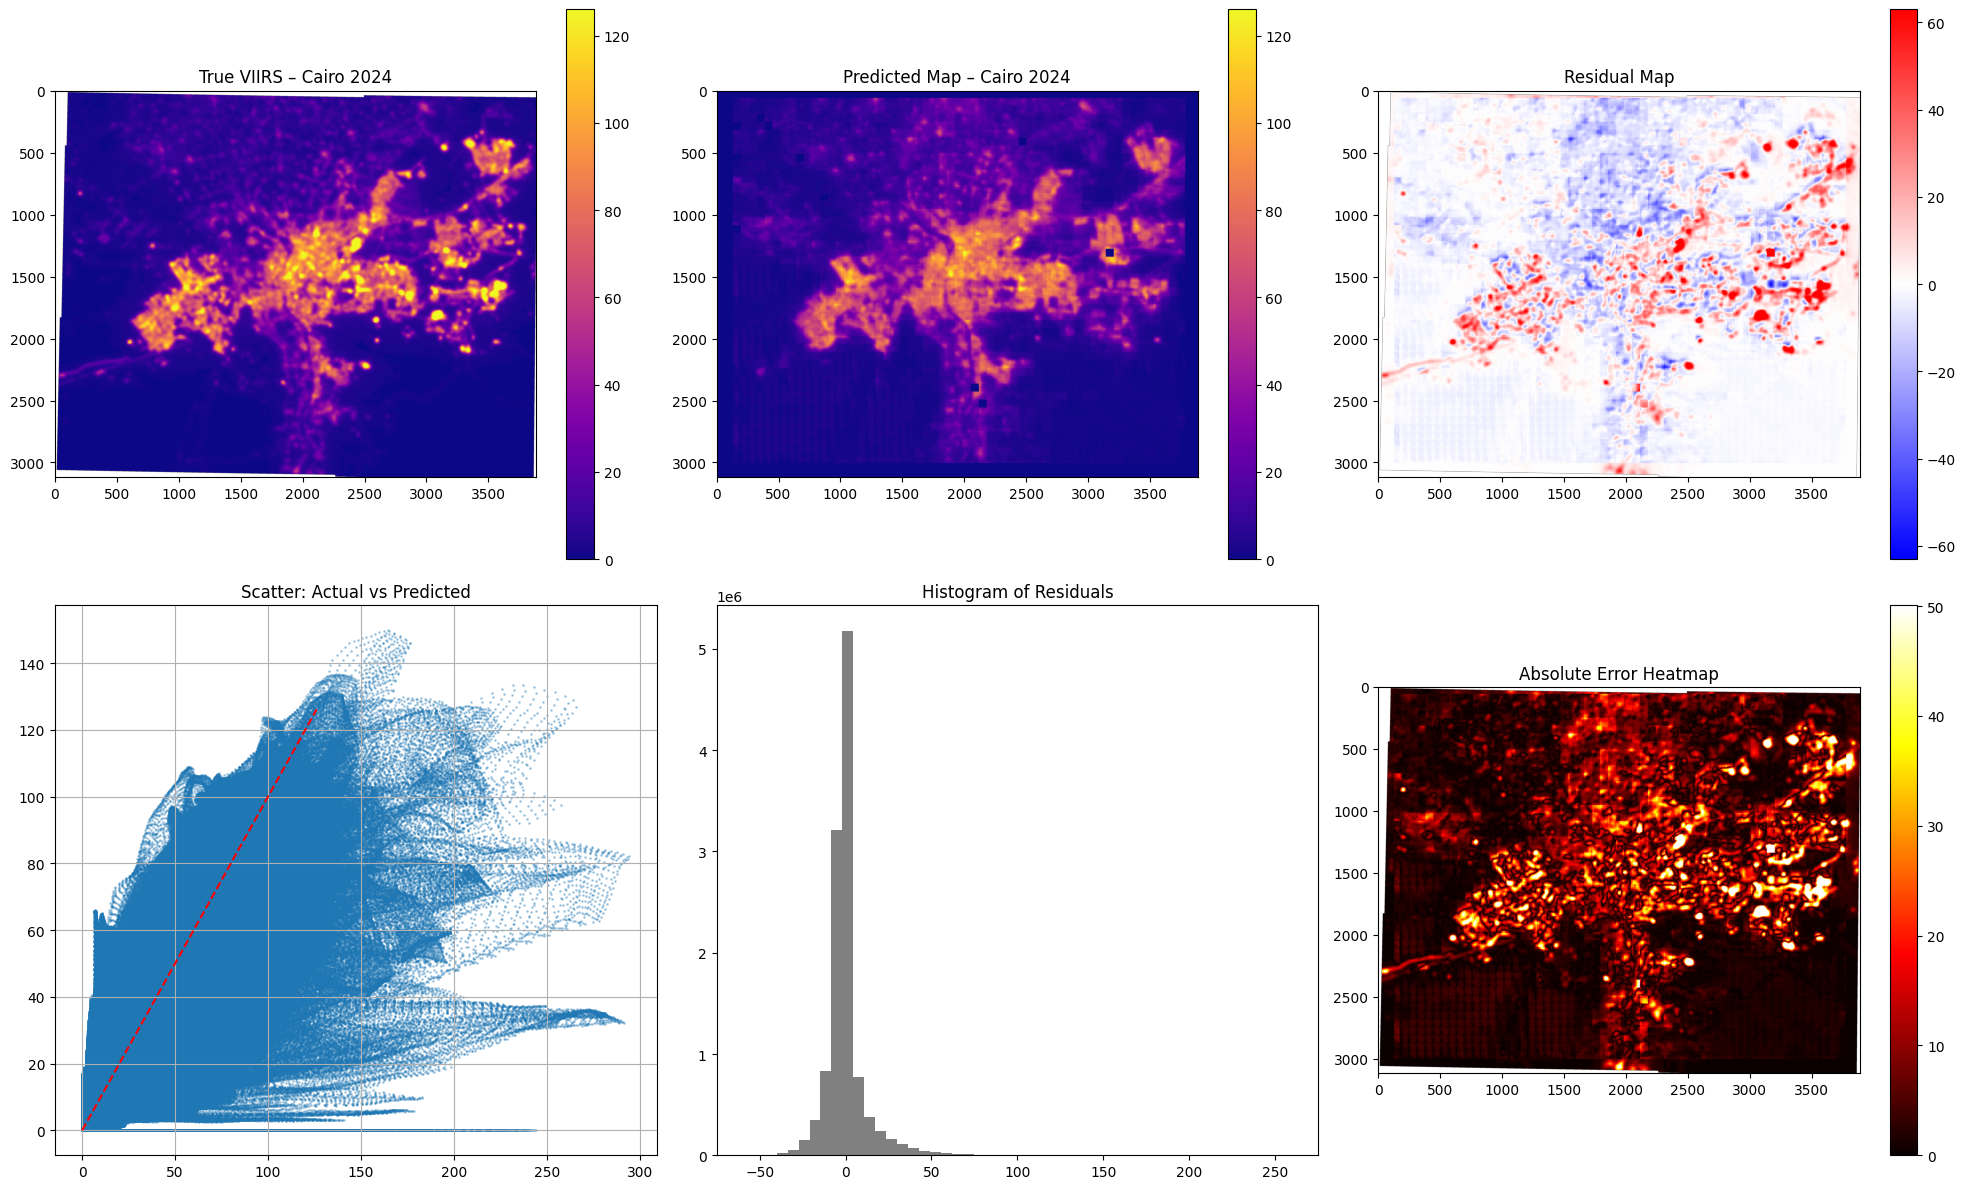

In [ ]:
vmax_2024 = np.nanpercentile(y_true_2024, 99.5)
residuals_2024 = y_true_2024 - y_pred_2024
abs_error_2024 = np.abs(residuals_2024)

plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.imshow(y_true_2024, cmap='plasma', vmin=0, vmax=vmax_2024)
plt.title("True VIIRS – Cairo 2024")
plt.colorbar()

plt.subplot(2, 3, 2)
plt.imshow(y_pred_2024, cmap='plasma', vmin=0, vmax=vmax_2024)
plt.title("Predicted Map – Cairo 2024")
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(residuals_2024, cmap='bwr', vmin=-vmax_2024/2, vmax=vmax_2024/2)
plt.title("Residual Map")
plt.colorbar()

plt.subplot(2, 3, 4)
plt.scatter(y_true_flat, y_pred_flat, alpha=0.3, s=1)
plt.plot([0, vmax_2024], [0, vmax_2024], 'r--')
plt.title("Scatter: Actual vs Predicted")
plt.grid(True)

plt.subplot(2, 3, 5)
plt.hist(residuals_2024[valid_mask].flatten(), bins=50, color='gray')
plt.title("Histogram of Residuals")

plt.subplot(2, 3, 6)
plt.imshow(abs_error_2024, cmap='hot', vmin=0, vmax=np.nanpercentile(abs_error_2024, 99))
plt.title("Absolute Error Heatmap")
plt.colorbar()

plt.tight_layout()
plt.show()


# Export Table to CSV

In [ ]:
df_metrics.to_csv("Cairo_Prediction_Metrics_Summary.csv", index=False)
